# **TechPoint Artificial Intelligence Work Sample**

By Benjamin Allen

10/15/23

## Imports and Setup

In [102]:
# Package Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pickle
import numpy as np

# Read in Dataset
order_data = pd.read_csv("/content/XTern 2024 Artificial Intelegence Data Set - Xtern_TrainData.csv")

# Part 1: Exploratory Data Analysis
This data set contains five columns, year, major, university, time, and order. For this project we would like to use year, major, university, and time as features to predict what a student will order. The data set features 5000 different observations. Finally, there is no missing data present in the data set. Now, let's look at the distributions of the different variables.

Columns: Index(['Year', 'Major', 'University', 'Time', 'Order'], dtype='object')
Dimensions (# row, # col):  (5000, 5)
Missing Data by Column 
 Year          0
Major         0
University    0
Time          0
Order         0
dtype: int64


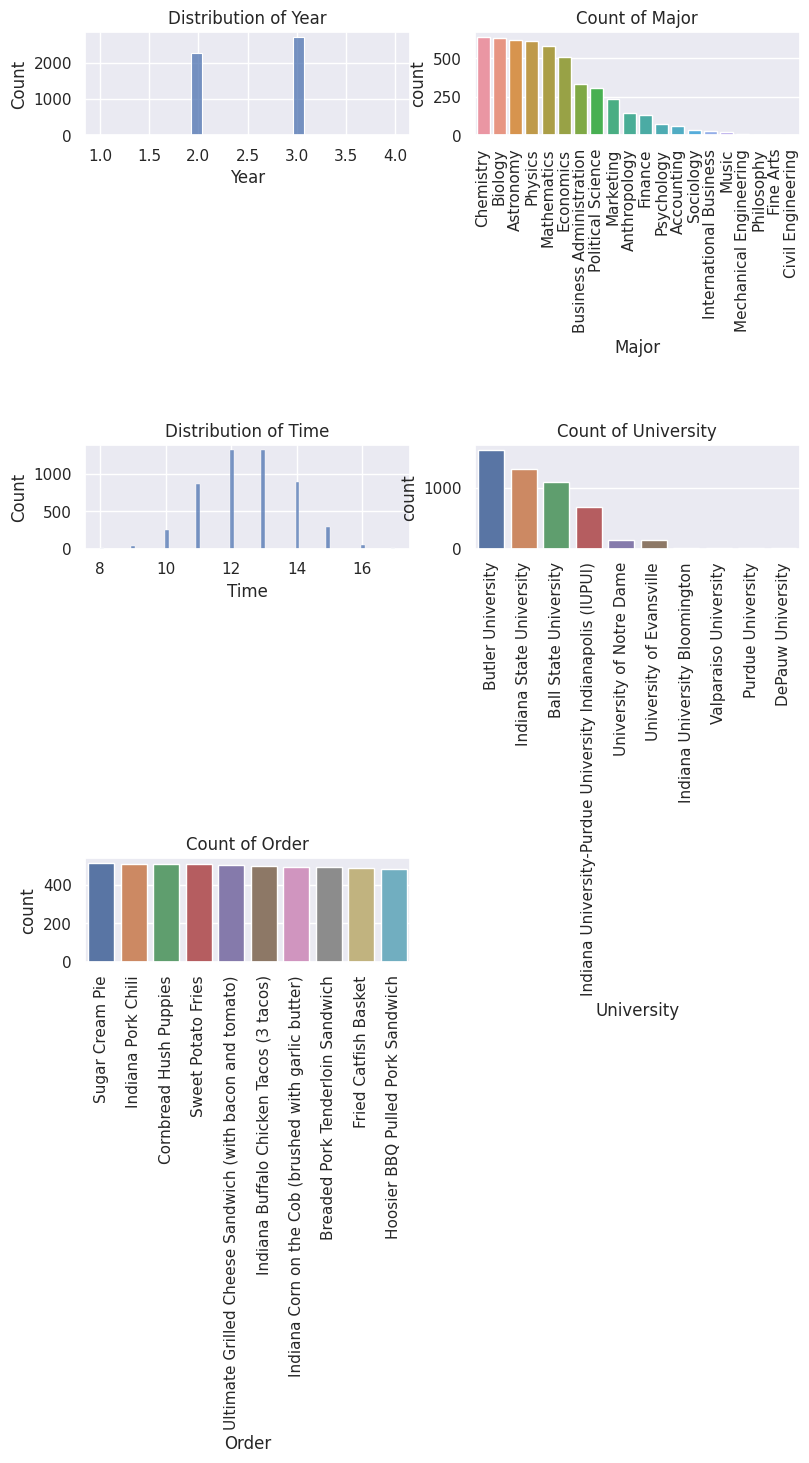

In [20]:
# Column names, Data Frame Shape, and Missing Data
print("Columns:", order_data.columns)
print("Dimensions (# row, # col): ", order_data.shape)
print("Missing Data by Column \n", order_data.isna().sum())

# Distributions of data

# Set up a grid for plotting
num_cols = order_data.select_dtypes(include=['int', 'float']).columns
cat_cols = order_data.select_dtypes(include=['object']).columns
total_cols = len(num_cols) + len(cat_cols)
cols_per_row = 2  # Number of columns per row in the grid
num_rows = total_cols // cols_per_row + (total_cols % cols_per_row > 0)

# Create a figure and axes for plotting
fig, axes = plt.subplots(nrows=num_rows, ncols=cols_per_row, figsize=(8, 10))
fig.tight_layout()

custom_col_order = ["Year", "Major", "Time", "University", "Order"]

# Loop through columns and create plots
for i, col in enumerate(custom_col_order):
    row = i // cols_per_row
    col_in_row = i % cols_per_row
    ax = axes[row, col_in_row]

    if col in num_cols:
        # For numerical columns, create a histogram
        sns.histplot(data=order_data, x=col, ax=ax)
        ax.set_title(f'Distribution of {col}')
    elif col in cat_cols:
        # For categorical columns, create a count plot
        sns.countplot(data=order_data, x=col, ax=ax, order=order_data[col].value_counts().index)
        ax.set_title(f'Count of {col}')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.subplots_adjust(wspace=0.2, hspace=3)

# Remove any empty subplots
for i in range(total_cols, num_rows * cols_per_row):
    fig.delaxes(axes.flatten()[i])

plt.show()

Beginning with the `Year` variable, we see that there are almost only 2nd and 3rd year students in this data set.

Next, for the `Major` variable, chemistry, biology, astronomy, physics, mathematics, and economics are the most popular majors among students. Given this, it appears that STEM majors are the most popular in this area.

The distribution of the `Time` variable shows that orders tend to be placed between noon and 1pm which makes sense as this is during lunchtime.

For the `University` variable, we see that more than 20% of students were from Butler University. The remaining students were largely from Indiana State, Ball State, or IUPUI.

Finally, we can see that our response variable, `Order`, is approximately uniformly distributed among the different possible orders. This is great as it will help us avoid the issue that often arise from class imbalances.

## Relationships Between Variables + Categorical Encoding

Now we want to look at the relationships between the different features. The first way we can do this is by using a correlation plot. To do this we will need to convert the categorical columns to numbers. For `Year`, we can do this by simply removing the string "Year" from each data point.

In [7]:
# Convert Year column to integer
order_data["Year"] = order_data["Year"].str.replace("Year", "").astype("int")

For the remaining categorical columns, it makes sense to use one-hot encoding as these columns do not have too many different categories. This is important as one-hot encoding adds a new column per distinct category, and we do not want our data to be too sparse.

In [8]:
# One-Hot Encode remaining categorical columns
encoded_data = pd.get_dummies(order_data)
encoded_data.head()

,Year,Time,Major_Accounting,Major_Anthropology,Major_Astronomy,Major_Biology,Major_Business Administration,Major_Chemistry,Major_Civil Engineering,Major_Economics,...,Order_Breaded Pork Tenderloin Sandwich,Order_Cornbread Hush Puppies,Order_Fried Catfish Basket,Order_Hoosier BBQ Pulled Pork Sandwich,Order_Indiana Buffalo Chicken Tacos (3 tacos),Order_Indiana Corn on the Cob (brushed with garlic butter),Order_Indiana Pork Chili,Order_Sugar Cream Pie,Order_Sweet Potato Fries,Order_Ultimate Grilled Cheese Sandwich (with bacon and tomato)
0,2,12,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,3,14,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,12,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2,11,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,3,12,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


We can now find the correlations in this data, and put them in a heat map. Given the number of columns we have now, we will first look at the correlations between the predictor variables.

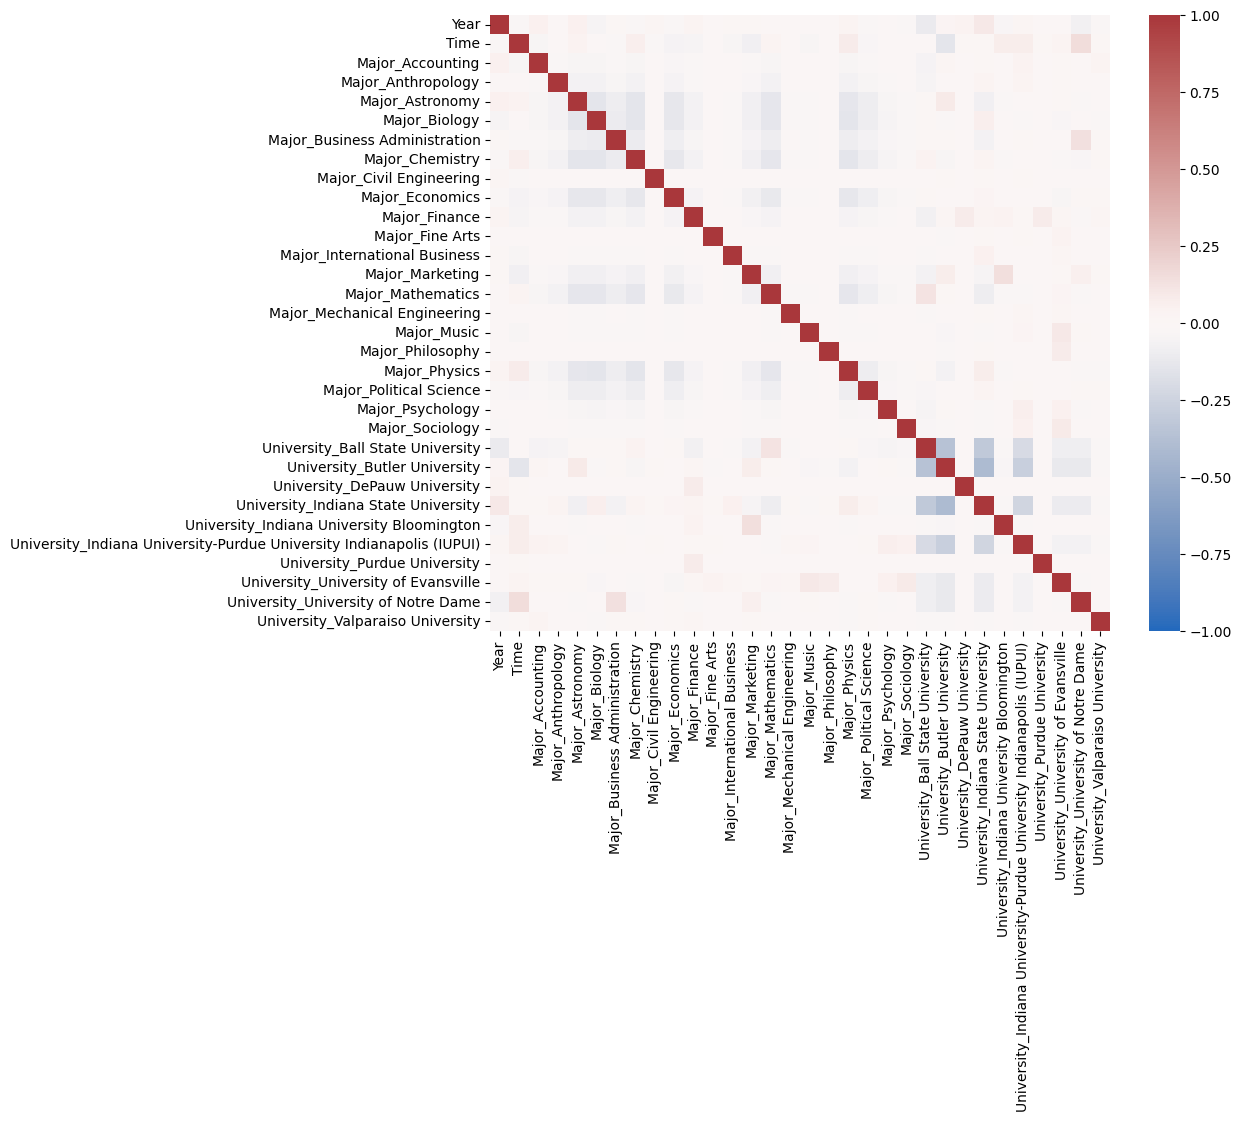

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(encoded_data.iloc[:, 0:32].corr(), vmin=-1, vmax=1, cmap="vlag")
sns.set(font_scale=1)
plt.show()

Looking at this plot, we can see that the predictors are largely uncorrelated, although there are some negative correlations between the encoded university variables. This makes sense as if a student is from one university then they cannot be from another university, so they should have a negative correlation.

Now let's look at the correlations of the order variables with the predictor variables.

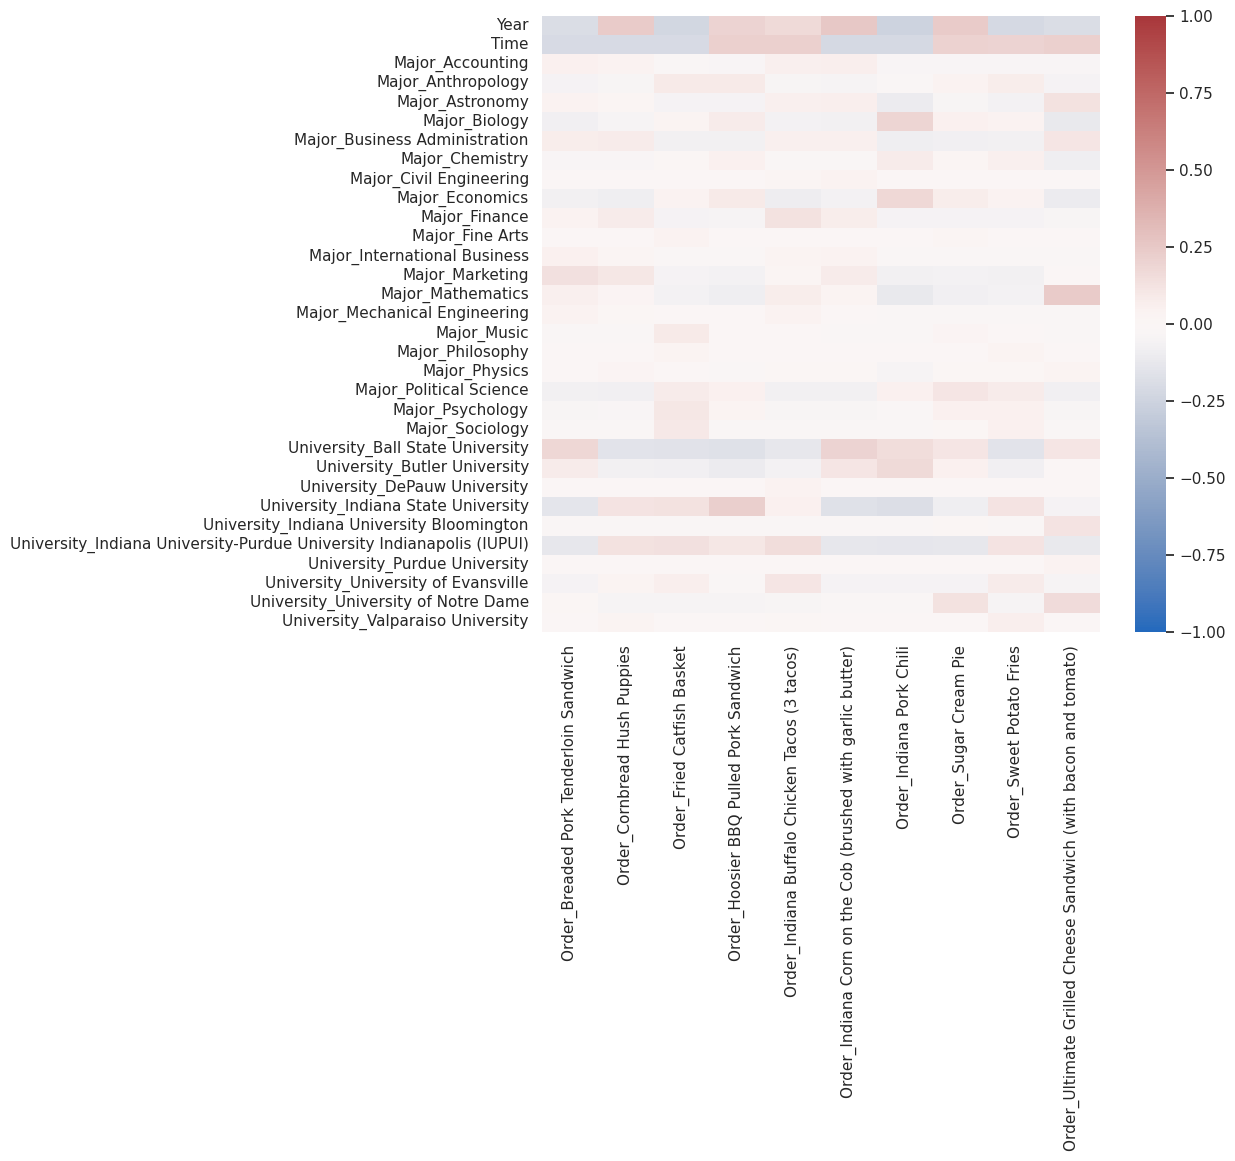

In [10]:
plt.figure(figsize=(9,8))
sns.heatmap(encoded_data.corr().iloc[0:32, 32:], cmap="vlag", vmin=-1, vmax=1)
sns.set(font_scale=1)
plt.show()

From this plot, we see that the grade year of the student and the time they order at have the highest correlations with what their actual order is. It also appears that students from Ball State, Butler, Indiana State, and IUPUI have stronger preferences as a group. This is indicated by the fact that the dummy variables for these universities have fairly high positive and negative correlations across the range of orders. A student's major appears to be less correlated with what they order, although there are still some moderately high correlations here and there that will be useful for prediction.

## Other Use Cases For The Data

Now thinking about how else this data could be used, we could analyse further what students from particular universities tend to order, and use the insights gained from that analysis to supply the food trucks at particular universities with more or less ingredients depending on how popular different orders tend to be. This would help FoodX reduce waste while ensuring that there is enough ingredients for popular items.

In a similar vein, we could look at what orders are most popular at particular times, and this could help inform FoodX whether or not it would be worthwhile to create a stockpile of a particular orders to meet demand more quickly and reduce wait times for customers.

## Data Collection, Storage, and Biases Discussion

### Ethical Implications

One major ethical concern with data collection would be forcing customers to give over their personal data, even if they do not really want to participate in the promotion. In this case, it would be a good ethical decision to let customers choose if they want to participate in the promotion and thus give out their personal information.


It is also important that the data collected is sufficiently anonymous, and it is not possible for a bad actor who gains access to the data set to use it for anything that could harm individual customers who participate in the promotion. Assuming that the features currently in the data set remain the same, this should not be a concern, as this data is not specific enough to tag it to individual people.

### Business Outcome Implications

On the business side, there are a few potential problems that may arise by collecting the data on college students in the data set. The biggest potential problem is that the promotion of 10% off if FoodX cannot predict what a student will order is too generous, and will end up losing it more money than it gains from customers gained from the promotion. This is where the performance of the model created in the following part becomes extremely importance, as the better the model, the more profitable the promotion will be.


The data collection and storage processes may also make some impact on the bottom line if FoodX uses a paid service to help streamline data collection, such as using a paid survey tool. Assuming that FoodX is not storing significantly more data than what is currently in the data set, it is unlikely that data storage will cost much of anything, as the data being stored is so small.


Another problem is lost revenue due to customers feeling uncomfortable with their data being collected and thus deciding not order from FoodX in the future. This problem could be alleviated by making the collection of this data from them optional.

### Technical Implications

For data collection, the main technical implication is figuring out how to have a streamlined process for collecting the data that does not heavily interfere with the normal ordering process. This may involve working with third party software or modifying the current ordering software to allow fot he data to be collected.


For data storage, care should be taken in deciding where and how the data is stored, with major considerations being ease of access, security, and what potential use cases the data will be used for.

# Part 2: Modeling

## 1. Model Selection, Training, and Testing Outline.
With the exploratory data analysis complete, it is now time to start creating a model for which to predict customer orders. From the previous analysis, all the features seem like they would be reasonably useful for predicting orders, so all the models created will use all the features present.

Now for the outline:

1. The data will need to be separated into a data frame containing the predictors and a data frame containing the orders which is the response variable.
2. We will need to encode the categorical predictor variables, so that they can be used in the model. We do not need to do this for the response variable however. This will be done with one-hot encoding for the `University` and `Major` variables, while `Year` will be converted to integers.
3. The data will then be split into a training a test set using an 80-20 scheme.
4. We will test Naive Bayes, LDA, QDA, and KNN models on the data because these models all work well on multiclass classification problems.
5. Hyperparameters will be tuned using cross validation, and performance will be measured based on accuracy, precision, recall, and F1 Score.
6. We will then select the best performing models of each type, and test these models on the test data. Which ever model performs best based again on accuracy, precision, recall, and F1 Score will be selected as the final model to be used for predictions.  

## 2. Data Cleaning Function

In [28]:
def data_cleaner(data_path):
  # Read in Dataset
  order_data = pd.read_csv("/content/XTern 2024 Artificial Intelegence Data Set - Xtern_TrainData.csv")

  # Create separate predictors and response
  X = order_data.iloc[:, 0:-1]
  y = order_data.loc[:, "Order"]

  # Convert Year variable
  X["Year"] = X["Year"].str.replace("Year", "").astype("int")

  # One-hot encode remaining categorical predictors
  X = pd.get_dummies(X, drop_first=True)

  return X, y

## 3. Model Training Function

In [45]:
def train_model(X_train, y_train, model, model_name):
  model.fit(X_train, y_train)
  results = cross_validate(model, X, y, cv=5, scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"])
  with open(f'{model_name}.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
  return pd.DataFrame(results)

## 4. Model Training and Testing

In [32]:
# Train Test Splitting
X, y = data_cleaner("/content/XTern 2024 Artificial Intelegence Data Set - Xtern_TrainData.csv")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=24)

### Naive Bayes

In [51]:
order_data["Order"].nunique()

10

In [53]:
nb_model = GaussianNB(priors=[0.1 for _itr in range(10)]) # Set uniform prior for classes
train_model(X_train, y_train, nb_model, 'nb_model')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.020852,0.050954,0.265,0.385509,0.264471,0.177124
1,0.019565,0.054227,0.221,0.353622,0.219818,0.157016
2,0.019762,0.051618,0.269,0.379765,0.267928,0.205398
3,0.019826,0.055327,0.239,0.351707,0.237400,0.181282
4,0.020010,0.050971,0.260,0.329152,0.258602,0.186133


Based on the performance metrics, the Naive Bayes model does not appear to do a very good job with this data on any level.

### Linear Discriminant Analysis (LDA)

LDA works by finding the coefficients that result in a linear combination (i.e. sum) of all the features that best separates the different classes from each other.

In [54]:
lda_model_base = LinearDiscriminantAnalysis() # Base Model
train_model(X_train, y_train, lda_model_base, 'lda_model_base')

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.127368,0.046184,0.595,0.596308,0.594013,0.588634
1,0.096587,0.121891,0.597,0.601725,0.595906,0.589672
2,0.074830,0.093898,0.611,0.613752,0.610267,0.606050
3,0.094213,0.111614,0.617,0.618916,0.616513,0.610309
4,0.060400,0.103960,0.590,0.593554,0.589645,0.583792


The base LDA model does a significantly better job with this data compared to the naive bayes model with an accuracy of around 60%, and similar scores for precision, recall, and f1 score. I also looked at tuning the shrinkage hyperparameter, however this did not result in any performance changes.

### Quadratic Discriminant Analysis (QDA)

QDA works very similarly to LDA with the main difference being that it assumes there is a quadratic decision boundary between classes rather than a linear one. This is useful for classifying data that feature non-linear relationships.

In [60]:
qda_model_base = QuadraticDiscriminantAnalysis() # Base Model
train_model(X_train, y_train, qda_model_base, 'qda_model_base')

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contro

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.060309,0.108370,0.204,0.387727,0.202491,0.133276
1,0.061043,0.103009,0.175,0.242611,0.173086,0.090064
2,0.054707,0.103650,0.209,0.345210,0.207139,0.127832
3,0.055911,0.098268,0.196,0.269678,0.194421,0.120067
4,0.056835,0.111899,0.205,0.449595,0.203653,0.119265


The QDA model performs even worse on this data than the naive bayes model, and appears to be fairly unstable from one cross-validation fold to the next.

### KNearest Neighbors (KNN)

KNN models are fairly simple, and classify points by essentially just looking at the k nearest ones, hence the name, and classify the point by what the majority of these nearest points are. The main hyperparameter model is the number of neighbors used to classify points.

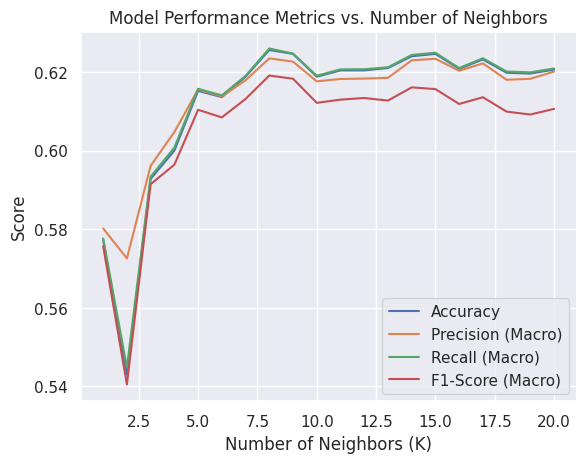

In [86]:
results_df = pd.DataFrame()
for k in np.arange(1, 21):
  knn_model = KNeighborsClassifier(n_neighbors=k)
  results = train_model(X_train, y_train, knn_model, f'knn_model_{k}')
  results_df = pd.concat([results_df, pd.Series(results.mean(), name=k)], axis=1)

# Plot the lines
sns.lineplot(data=results_df.transpose(), x=np.arange(1, 21), y="test_accuracy", label="Accuracy")
sns.lineplot(data=results_df.transpose(), x=np.arange(1, 21), y="test_precision_macro", label="Precision (Macro)")
sns.lineplot(data=results_df.transpose(), x=np.arange(1, 21), y="test_recall_macro", label="Recall (Macro)")
sns.lineplot(data=results_df.transpose(), x=np.arange(1, 21), y="test_f1_macro", label="F1-Score (Macro)")

# Add labels and title
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Score")
plt.title("Model Performance Metrics vs. Number of Neighbors")

# Add a legend
plt.legend(loc='best')

# Display the plot
plt.show()

Based on the performance results, the model performed best on the performance metrics when the number of neighbors was equal to 8. The model performed fairly similarly after this point, so it does not make sense to add more neighbors without a corresponding performance increase.

## Final Model Selection

With all the models trained and hyperparameters tuned, we can now compare all the models on the testing data to select the final model. The only model where hyperparameter tuning was particularly useful was for the KNN model, so for the other model we will just use the base model.

In [89]:
# Get metrics from testing set function
def test_metrics(fitted_model, X_test, y_test):
  predictions = fitted_model.predict(X_test)
  accu = round(accuracy_score(predictions, y_test), 4)
  prec = round(precision_score(predictions, y_test, average='macro'), 4)
  reca = round(recall_score(predictions, y_test, average='macro'), 4)
  f1 = round(f1_score(predictions, y_test, average='macro'), 4)
  return accu, prec, reca, f1

In [101]:
# Calculate metrics
nb_results = test_metrics(nb_model, X_test, y_test)
lda_results = test_metrics(lda_model_base, X_test, y_test)
qda_results = test_metrics(qda_model_base, X_test, y_test)
# Get knn model with 8 neighbors
with open('/content/knn_model_8.pkl', 'rb') as file:
    knn_model = pickle.load(file)
knn_results = test_metrics(knn_model, X_test, y_test)

# Output results
print('(Accuracy, Precision, Recall, F1 Score)')
print('[NB]:', nb_results)
print('[LDA]:', lda_results)
print('[QDA]:', qda_results)
print('[KNN]:', knn_results)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(Accuracy, Precision, Recall, F1 Score)
[NB]: (0.247, 0.2487, 0.3521, 0.1667)
[LDA]: (0.617, 0.6232, 0.6177, 0.6134)
[QDA]: (0.18, 0.1841, 0.3475, 0.1018)
[KNN]: (0.627, 0.6293, 0.6235, 0.6234)


From these results, we can see that across all the metrics the LDA and KNN models are the clear winners with KNN edging out the LDA model overall. Therefore **a KNN model with k=8** is best suited for this order prediction task. We can gain a bit more insight into the model by looking at its confusion matrix below.

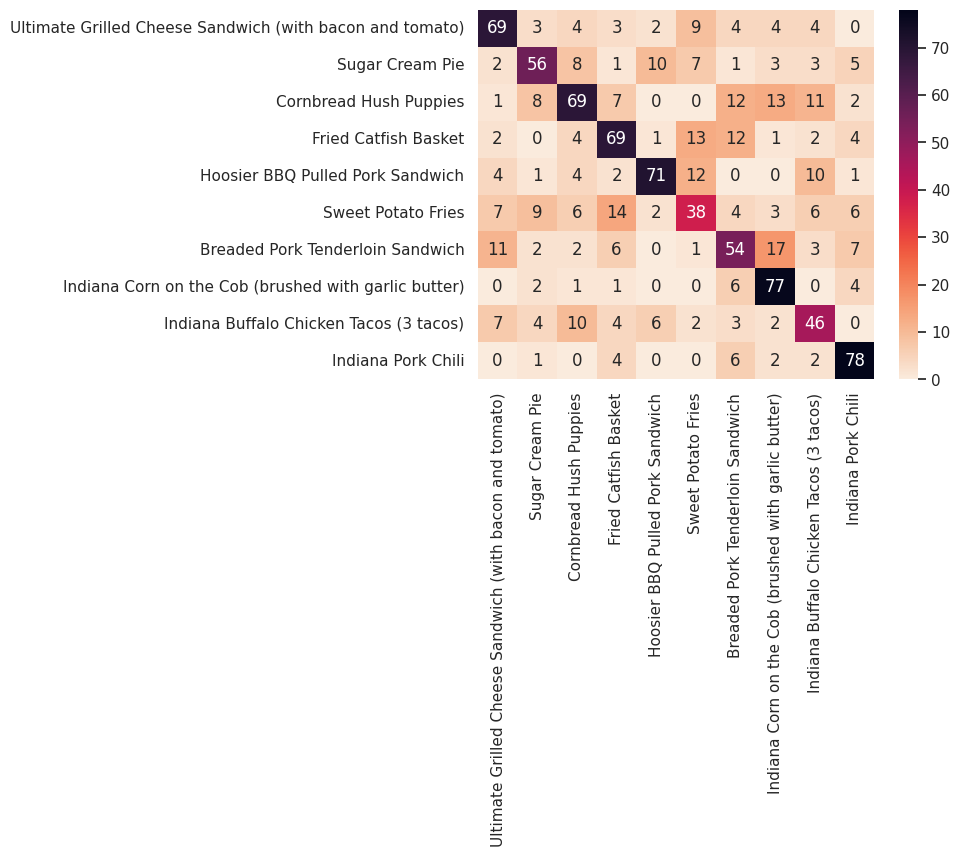

In [117]:
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, knn_model.predict(X_test), labels=y_test.unique()),
                         columns=y_test.unique(), index=y_test.unique()), annot=True, cmap=sns.cm.rocket_r)
plt.show()

From this confusion matrix, we can see that the model had the most trouble predicting orders for the sweet potato fries and Indiana buffalo chicken tacos, while it did the best predicting the Indiana pork chili and Indiana corn on the cob.

## Model Viability

Overall, creating this model was not particularly time-intensive, however with an overall accuracy of about 63%, it may not be accurate enough yet. The model is obviously doing a lot better than a random model because a random model would have an accuracy of about 10% given that there are 10 orders to choose from. Ultimately, the main consideration is whether the promotion is expected to increase profit by more than would be lost by giving people 10% off their orders when the model incorrectly predicts orders. We expect the model to be wrong 37% of the time, and assuming every customer we have goes along with the promotion, that means we would see a cut in profits of 3.7% on average. Therefore, for the promotion to be worthwhile, we would need to see a greater than 3.7% increase in profits due to increased demand generated by the promotion. To do this, we could run the promotion on a limited scale to get some preliminary results, or we could make some educated guesses as to how effective the promotion will be based on past promotions and sales.


An important thing to note is that we also need to account for the costs of setting up the data collection and storage infrastructure which will vary widely depending on implementation.